# General feedback
First of all, your project is accepted! You've done an amazing job! I want to highlight the beautiful design of the notebook separately. I really liked that the comments are written only in markdowns. And I also want to highlight the introductions and conclusions. Also the graphics are flawless! The analysis is also done extremely professionally!


Good luck in future learning! 

# Statistical Data Analysis Project
This is a data analysis made for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

We are going to carry out a preliminary analysis of the plans based on a relatively small client selection. We'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Our goal is to analyze clients' behavior and determine which prepaid plan brings in more revenue.

## Raw Data
Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt, factorial

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv', parse_dates=['call_date'])
internet = pd.read_csv('/datasets/megaline_internet.csv', parse_dates=['session_date'])
messages = pd.read_csv('/datasets/megaline_messages.csv', parse_dates=['message_date'])
plans = pd.read_csv('/datasets/megaline_plans.csv', index_col='plan_name')
users = pd.read_csv('/datasets/megaline_users.csv', parse_dates=['reg_date'])

### Users
Column descriptions:

`user_id` — unique user identifier

`first_name` — user's name

`last_name` — user's last name

`age` — user's age (years)

`reg_date` — subscription date (dd, mm, yy)

`churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)

`city` — user's city of residence

`plan` — calling plan name

In [3]:
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
226,1226,Denver,Harrell,64,"Riverside-San Bernardino-Ontario, CA MSA",2018-03-15,ultimate,NaN
173,1173,Tristan,Cain,27,"Oxnard-Thousand Oaks-Ventura, CA MSA",2018-09-28,surf,NaN
320,1320,Bert,Wells,23,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-02-23,surf,NaN
420,1420,Season,Hardy,27,"San Francisco-Oakland-Berkeley, CA MSA",2018-02-22,ultimate,NaN
145,1145,Venice,Brooks,29,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-12,surf,NaN


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [5]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,45.486,16.972269,18.0,30.00,46.0,61.00,75.0


In [6]:
users.describe(include=np.object).T

,count,unique,top,freq
first_name,500,458,Leonila,3
last_name,500,399,Reese,3
city,500,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",80
plan,500,2,surf,339
churn_date,34,29,2018-12-18,3


We have data on 500 users from 73 cities, aged 18 to 75 years, 339 of which used the Surf plan (68%) while 161 used the Ultimate plan (32%).

### Calls
Column descriptions:

`id` — unique call identifier

`call_date` — call date

`duration` — call duration (in minutes)

`user_id` — the identifier of the user making the call

In [7]:
calls.sample(5)

,id,user_id,call_date,duration
17255,1066_363,1066,2018-12-05,9.77
63343,1231_57,1231,2018-10-28,1.24
1503,1008_144,1008,2018-10-20,7.29
107015,1380_54,1380,2018-11-02,5.69
69701,1249_674,1249,2018-09-25,13.17


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [9]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,137735.0,1247.658046,139.416268,1000.0,1128.00,1247.00,1365.00,1499.0
duration,137735.0,6.745927,5.839241,0.0,1.29,5.98,10.69,37.6


In [10]:
calls.groupby('user_id')['duration'].sum().describe()

count     481.000000
mean     1931.705322
std      1609.701658
min         4.600000
25%       737.930000
50%      1456.660000
75%      2724.160000
max      8950.280000
Name: duration, dtype: float64

In [11]:
print('Mean total call time (minutes):', calls['duration'].sum() / len(users))

Mean total call time (minutes): 1858.3005199999996


481 of our 500 users used calls (96%). The mean call time was 6 minutes and 45 seconds, and the mean total call time for 2018 was 1858 minutes. The biggest talker used 8950 minutes.

### Messages
Column descriptions:

`id` — unique text message identifier

`message_date` — text message date

`user_id` — the identifier of the user sending the text

In [12]:
messages.sample(5)

,id,user_id,message_date
37775,1250_28,1250,2018-11-19
46473,1316_363,1316,2018-08-06
74292,1476_51,1476,2018-12-27
75334,1491_130,1491,2018-12-13
18937,1123_6,1123,2018-12-19


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [14]:
messages.groupby('user_id')['id'].count().describe()

count     402.000000
mean      189.181592
std       192.207920
min         1.000000
25%        60.000000
50%       126.500000
75%       258.750000
max      1288.000000
Name: id, dtype: float64

In [15]:
print('Mean total messages:', len(messages) / len(users))

Mean total messages: 152.102


402 out of 500 user used messages (80%). The per user mean was 152.1 messages, and at most 1288 were sent by a single user.

### Internet
Column descriptions:

`id` — unique session identifier

`mb_used` — the volume of data spent during the session (in megabytes)

`session_date` — web session date

`user_id` — user identifier

In [16]:
internet.sample(5)

,id,user_id,session_date,mb_used
41112,1185_149,1185,2018-12-25,0.00
46897,1209_125,1209,2018-09-17,558.18
36188,1163_169,1163,2018-09-06,0.00
13350,1062_320,1062,2018-10-20,530.45
96870,1456_164,1456,2018-09-03,297.29


In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [18]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,104825.0,1242.496361,142.053913,1000.0,1122.00,1236.00,1367.00,1499.00
mb_used,104825.0,366.713701,277.170542,0.0,136.08,343.98,554.61,1693.47


In [19]:
internet.groupby('user_id')['mb_used'].sum().describe()

count       489.000000
mean      78610.968732
std       61940.374028
min          92.680000
25%       29401.530000
50%       62354.370000
75%      115737.760000
max      390159.350000
Name: mb_used, dtype: float64

In [20]:
print('Mean total data usage (MB):', internet['mb_used'].sum() / len(users))

Mean total data usage (MB): 76881.52742


489 out of 500 user used data (98%). The mean data usage per session was 367 megabytes and the mean data usage per user was 76.9 gigabytes. The heavieast user user used slightly more than 390 gigabytes, about 5 times more than average.

### Plans
Column descriptions:

`plan_name` — calling plan name

`usd_monthly_fee` — monthly charge in US dollars

`minutes_included` — monthly minute allowance

`messages_included` — monthly text allowance

`mb_per_month_included` — data volume allowance (in megabytes)

`usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)

`usd_per_message` — price per text after exceeding the package limits

`usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [21]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15360,500,20,10,0.03,0.03
ultimate,1000,30720,3000,70,7,0.01,0.01


Here we have a handy table of the conditions for each of the plans.

## Data Preprocessing
For each user, we will find:
- The number of calls made and minutes used per month
- The number of text messages sent per month
- The volume of data per month
- The monthly revenue

### Monthly Stats

We start by making a new pivot table for each of `calls`, `messages` and `internet`. This will give us the total monthly values that we need.

In [22]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
m_calls = calls.pivot_table(values='duration', 
                  index=('user_id', 'month'), 
                  aggfunc=['count', 'sum']
                 ).set_axis(['calls', 'minutes'], axis=1, inplace=False)
m_calls.head()

calls  minutes
user_id month                
1000    12        16   116.83
1001    8         27   171.14
        9         49   297.69
        10        65   374.11
        11        64   404.59

In [23]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
m_messages = messages.pivot_table(values='id', 
                     index=('user_id', 'month'), 
                     aggfunc='count'
                    ).set_axis(['messages'], axis=1, inplace=False)
m_messages.head()

messages
user_id month          
1000    12           11
1001    8            30
        9            44
        10           53
        11           36

In [24]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
m_internet = internet.pivot_table(values='mb_used', 
                  index=('user_id', 'month'), 
                  aggfunc='sum'
                 ).set_axis(['mb_used'], axis=1, inplace=False)
m_internet.head()

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30

### Merging Tables
Next, put it all in one dataset, along with plan and city.

In [25]:
df = (
      pd.concat([m_calls, m_messages, m_internet], axis=1)
      .fillna(0)
      .reset_index()
      .merge(users[['user_id', 'city', 'plan']], on='user_id')
     )
df['minutes'] = np.ceil(df['minutes'])
df.head()

,user_id,month,calls,minutes,messages,mb_used,city,plan
0,1000,12,16.0,117.0,11.0,1901.47,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,8,27.0,172.0,30.0,6919.15,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1001,9,49.0,298.0,44.0,13314.82,"Seattle-Tacoma-Bellevue, WA MSA",surf
3,1001,10,65.0,375.0,53.0,22330.49,"Seattle-Tacoma-Bellevue, WA MSA",surf
4,1001,11,64.0,405.0,36.0,18504.30,"Seattle-Tacoma-Bellevue, WA MSA",surf


Next we'll creat an `area` column based on `city`.

In [26]:
df['area'] = df['city'].str.split(',', expand=True)[1].str.split(' ', expand=True)[1]
df = df.drop(['city'], axis=1)

df.sample(5)

,user_id,month,calls,minutes,messages,mb_used,plan,area
848,1176,12,68.0,405.0,76.0,25808.24,surf,NY-NJ-PA
1525,1332,8,41.0,253.0,0.0,24322.34,surf,GA
1007,1211,9,41.0,311.0,50.0,17759.72,ultimate,NY-NJ-PA
493,1104,12,4.0,9.0,25.0,9360.99,ultimate,IL-IN-WI
1492,1325,12,67.0,402.0,0.0,27752.94,surf,TX


### Calculating Revenue
And finally, we'll calculate the monthly revenue for each user and month.

In [27]:
def revenue(row):
    plan = row['plan']
    if plan not in ['surf', 'ultimate']:
        return 0
    s = plans.loc[plan, 'usd_monthly_pay']
    if row['messages'] > plans.loc[plan, 'messages_included']:
        s += (row['messages'] - plans.loc[plan, 'messages_included']) * plans.loc[plan, 'usd_per_message']
    if row['minutes'] > plans.loc[plan, 'minutes_included']:
        s += (row['minutes'] - plans.loc[plan, 'minutes_included']) * plans.loc[plan, 'usd_per_minute']    
    if row['mb_used'] > plans.loc[plan, 'mb_per_month_included']:
        excess = row['mb_used'] - plans.loc[plan, 'mb_per_month_included']
        gb_used = int(excess / 1000) + (excess % 1000 > 0)
        s += gb_used * plans.loc[plan, 'usd_per_gb']
    return s


In [28]:
df['revenue'] = df.apply(revenue, axis=1)

df.sample(5)

,user_id,month,calls,minutes,messages,mb_used,plan,area,revenue
1076,1226,9,75.0,515.0,0.0,22213.05,ultimate,CA,70.00
181,1045,11,77.0,536.0,49.0,24871.18,surf,NY-NJ-PA,121.08
1556,1336,11,107.0,711.0,77.0,17539.04,surf,OR-WA,57.14
943,1196,5,66.0,405.0,30.0,23429.34,ultimate,CA,70.00
1800,1389,5,60.0,393.0,0.0,13713.87,ultimate,FL,70.00


### Data Types
Now that we have the dataset we will work on, let's rectify its data types.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
user_id     2293 non-null int64
month       2293 non-null int64
calls       2293 non-null float64
minutes     2293 non-null float64
messages    2293 non-null float64
mb_used     2293 non-null float64
plan        2293 non-null object
area        2293 non-null object
revenue     2293 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 179.1+ KB


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2293.0,1246.075883,143.051927,1000.0,1122.00,1245.00,1368.00,1499.00
month,2293.0,9.172700,2.496386,1.0,8.00,10.00,11.00,12.00
calls,2293.0,60.067597,32.402563,0.0,38.00,60.00,79.00,205.00
minutes,2293.0,405.708242,223.404711,0.0,250.00,401.00,541.00,1432.00
messages,2293.0,33.166594,34.070085,0.0,3.00,26.00,51.00,266.00
mb_used,2293.0,16764.397606,7967.237527,0.0,12235.76,16830.64,20999.84,70931.59
revenue,2293.0,64.612791,47.487482,20.0,22.49,70.00,70.00,598.66


In [31]:
for column in ['user_id', 'month', 'calls', 'minutes', 'messages']:
    df[column] = df[column].astype('int16')
    
for column in ['mb_used', 'revenue']:
    df[column] = df[column].astype('float32')

## Analysis
Below are the calculated mean, dispersion, standard deviation and median of the minutes, texts, and volume of data the users of each plan require per month. 

In [32]:
df.pivot_table(values=['minutes', 'messages', 'mb_used', 'revenue'], columns='plan', aggfunc=['mean', 'var', 'std', 'median'])

mean                         var                        std  \
plan              surf      ultimate          surf      ultimate         surf   
mb_used   16558.283203  17214.699219  6.421640e+07  6.165229e+07  8013.513337   
messages     31.159568     37.551389  1.126725e+03  1.208757e+03    33.566717   
minutes     405.250477    406.708333  4.914399e+04  5.165166e+04   221.684445   
revenue      61.056664     72.381943  3.184661e+03  1.376383e+02    56.432798   

                             median                
plan         ultimate          surf      ultimate  
mb_used   7851.897350  16829.310547  16858.339844  
messages    34.767179     24.000000     30.000000  
minutes    227.270019    402.000000    399.000000  
revenue     11.731937     40.360001     70.000000

To better understand the distributions of the above parameters, we'll plot histograms for each.

### Calls

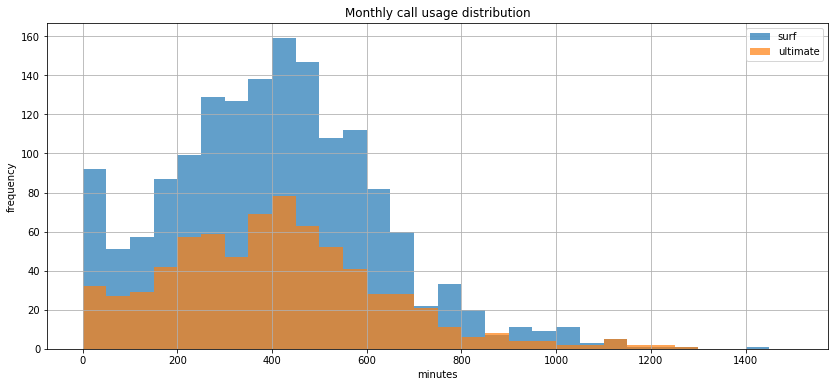

In [33]:
plt.figure(figsize=(14, 6))
min_bin = list(range(0,1501, 50))
plt.hist(df.query('plan == "surf"')['minutes'], bins=min_bin, label='surf', alpha=0.7)
plt.hist(df.query('plan == "ultimate"')['minutes'], bins=min_bin, label='ultimate', alpha=0.7)
plt.xlabel('minutes')
plt.ylabel('frequency')
plt.title('Monthly call usage distribution')
plt.grid()
plt.legend()
plt.show()

Users of both plans spoke on the phone an average of about 405 minutes a month. This number coincides with the peak in the call usage distribution. The medians are slightly lower, meaning the histograms are gently right skewed. In the Surf histogram only, there's a secondary peak near zero, of users who barely made calls. Other than that, the distributions are quiet similar.

### Messages

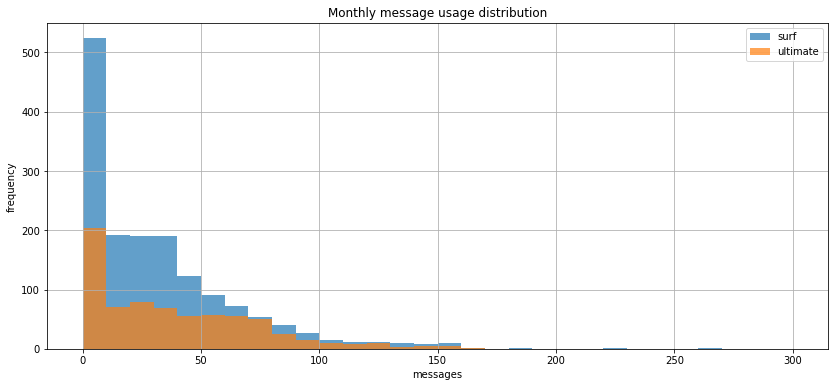

In [34]:
plt.figure(figsize=(14, 6))
msg_bin = list(range(0,301, 10))
plt.hist(df.query('plan == "surf"')['messages'], bins=msg_bin, label='surf', alpha=0.7)
plt.hist(df.query('plan == "ultimate"')['messages'], bins=msg_bin, label='ultimate', alpha=0.7)
plt.xlabel('messages')
plt.ylabel('frequency')
plt.title('Monthly message usage distribution')
plt.grid()
plt.legend()
plt.show()

As we know, 20% of users didn't use messages at all. The prominent peak near zero and long tail make it hard to understand the rest of the figure, so we'll readjust to exclude outliers.

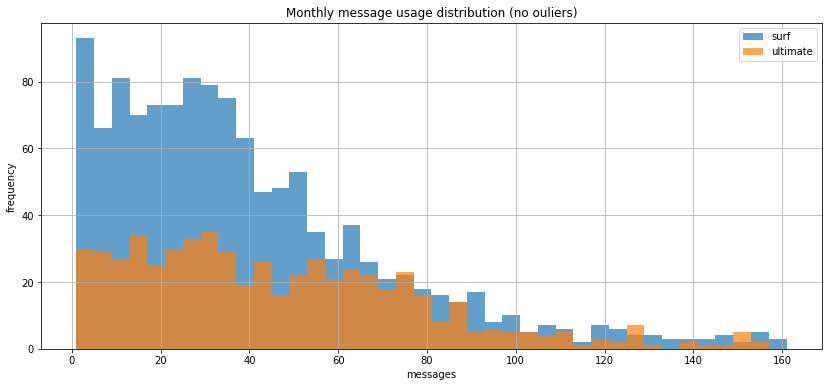

In [35]:
plt.figure(figsize=(14, 6))
msg_bin = list(range(1,162, 4))
plt.hist(df.query('plan == "surf"')['messages'], bins=msg_bin, label='surf', alpha=0.7)
plt.hist(df.query('plan == "ultimate"')['messages'], bins=msg_bin, label='ultimate', alpha=0.7)
plt.xlabel('messages')
plt.ylabel('frequency')
plt.title('Monthly message usage distribution (no ouliers)')
plt.grid()
plt.legend()
plt.show()

Surf and Ultimate users sent an average 31 and 37.5 messages a month, medians 24 and 30, respectivaely. In other words, Ultimate users tend to send more messages, and both are right skewed.

### Data

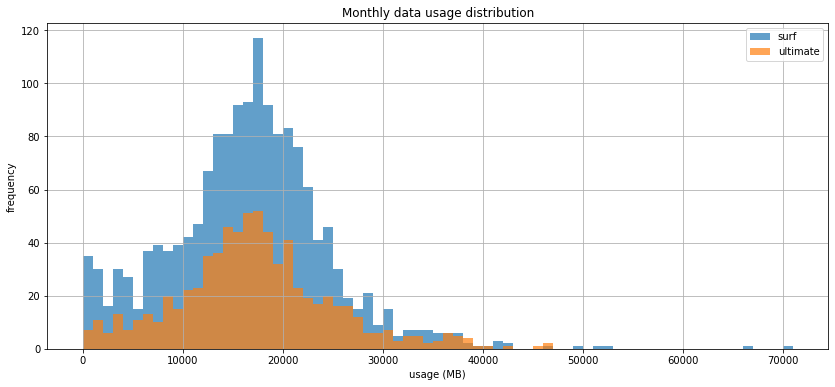

In [36]:
plt.figure(figsize=(14, 6))
data_bin = list(range(0,71001, 1000))
plt.hist(df.query('plan == "surf"')['mb_used'], bins=data_bin, label='surf', alpha=0.7)
plt.hist(df.query('plan == "ultimate"')['mb_used'], bins=data_bin, label='ultimate', alpha=0.7)
plt.xlabel('usage (MB)')
plt.ylabel('frequency')
plt.title('Monthly data usage distribution')
plt.grid()
plt.legend()
plt.show()

The mean data usage of Surf users is 16558 MB/month while for Ultimate users it is 17215 MB/month, around 650 MB difference in favor of Ultimate. The median for both is about 16850 MB/month, meaning the Surf graph is left skewed and the Ultimate graph is right skewed. Ultimate users, on average, take advantage of their larger data allowence.

### Revenue

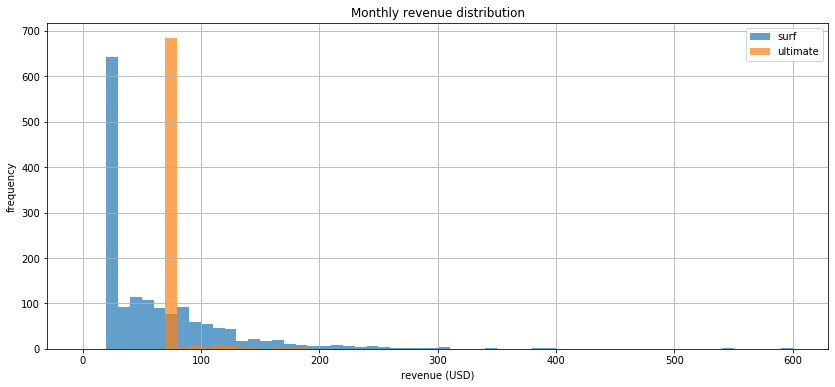

In [37]:
plt.figure(figsize=(14, 6))
rev_bin = list(range(0,601, 10))
plt.hist(df.query('plan == "surf"')['revenue'], bins=rev_bin, label='surf', alpha=0.7)
plt.hist(df.query('plan == "ultimate"')['revenue'], bins=rev_bin, label='ultimate', alpha=0.7)
plt.xlabel('revenue (USD)')
plt.ylabel('frequency')
plt.title('Monthly revenue distribution')
plt.grid()
plt.legend()
plt.show()

No surprise, Ultimate users hardly go over their allowences. For Surf users, however, the story is more complex. There is a prominent peak at 20 USD, but the median is 40 USD and mean is 60 USD. It's strongly skewed to the right. Some significant portion even end up paying more than 70 USD a month. Let's check how many exactly.

In [38]:
df2 = df.groupby('user_id')['revenue'].mean().reset_index().merge(users[['user_id', 'plan']], on='user_id')
print('{:.0%}'.format(len(df2.query('plan == "surf" and revenue > 70')) / len(df2.query('plan == "surf"'))))

26%


So about 1 in 4 Surf users pays over 70 USD a month on average, and would have been better off with the Ultimate plan.

## Hypotheses Testing
In this section we'll use a statistical method named t-testing to test two hypotheses:
- The average revenue from users of Ultimate and Surf calling plans differs.
- The average revenue from users in NY-NJ area is different from that of the users from other regions.

We will decide whether to reject the null hypothesis according to the p-value obtained by t-testing. The lower the p-value, the less likely it is that our sample means are as far as they are, assuming the null hypothesis. The lower threshold commonly used with this method is $\alpha$=0.05, meaning, if p-value falls below $\alpha$, the null hypothesis is rejected. We will also use $\alpha$=0.05. 

### Plan Dependency

Our hypothesis states that the average revenue from users of Ultimate and Surf calling plans differs. The null hypothesis is, therefore, that there is no difference in mean revenue between the groups. We know from previous results that the variance differs.

In [39]:
alpha = 0.05

In [40]:
results = st.ttest_ind(df.query('plan == "surf"')['revenue'], 
                       df.query('plan == "ultimate"')['revenue'], 
                       equal_var=False,
                      )

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('The average revenue from users of Ultimate and Surf calling plans differs.')
else:
    print('The null hypothesis cannot be rejected.')

p-value: 4.396664374474546e-14
The average revenue from users of Ultimate and Surf calling plans differs.


### Area Dependency

Our hypothesis was that the average revenue from users in NY-NJ area is different from that of the users from other regions. Conversely, the null hypothesis is that there is no difference in average revenue between NY-NJ and other areas. We don't have a reason to assume the variance is equal.

In [41]:
results = st.ttest_ind(df.query('"NY" in area or "NJ" in area')['revenue'], 
                       df.query('~("NY" in area or "NJ" in area)')['revenue'], 
                       equal_var=False,
                      )

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('The average revenue from users in NY-NJ area is different from that of the users from other regions.')
else:
    print('The null hypothesis cannot be rejected.')

p-value: 0.37594316688749174
The null hypothesis cannot be rejected.


## Conclusions

- We looked at data of 500 users of both Surf and Ultimate plans, representing a range of ages and locations.
- Nearly all users used internet and calls to some degree, while 20% didn't use messages at all.
- We prepared a table of per user, per month usages and used it to calculate revenue.
- There was no significant difference in call usage between users of different plans.
- Users of the Ultimate plan tend to use more data and messages than Surf plan users.
- About 1 in 4 Surf users pays over 70 USD a month on average, and would have been better off with the Ultimate plan.
- The average revenue from users of Ultimate and Surf calling plans differs, in favor of Ultimate.
- No revenue dependence on location was found when comparing the NY-NJ area to the rest of the country.